# Importing some packages

In [4]:
import pandas as pd

from pathlib import Path
import os
from bisect import bisect

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from scipy.stats import ks_2samp

# from evidently.dashboard import Dashboard
# from evidently.tabs import DataDriftTab, CatTargetDriftTab

# from evidently.model_profile import Profile
# from evidently.profile_sections import DataDriftProfileSection

import re

import warnings
warnings.filterwarnings('ignore')

# Loading data

In [5]:
data = pd.read_csv('data.csv')

# EDA

In [4]:
data.head()

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.457733    
4                                           0.522298    

    Operating Gross Margin   Realized Sales Gross Margin  \
0                 0.601457                      0.601457   
1                 0.610235                      0.610235   
2                 0.601450                      0.601364   
3                 0.583541                      0.583541   
4                 0.598783                      0.598783   

    Operating Profit Rate   Pre-tax net Interest Rate  \
0                0.998969                    0.796887   
1                0.998946                    0.797380   
2                0.998857                    0.796403   
3                0.998700                    0.796967   
4                0.998973                    0.797366   

    After-tax net Interest Rate   Non-industry income and expenditure/revenue  \
0                      0.808809                                      0.302646   
1                      0.809301                                      0.303556   
2                      0.808388                                      0.302035   
3                      0.808966                                      0.303350   
4                      0.809304                                      0.303475   

   ...   Net Income to Total Assets   Total assets to GNP price  \
0  ...                     0.716845                    0.009219   
1  ...                     0.795297                    0.008323   
2  ...                     0.774670                    0.040003   
3  ...                     0.739555                    0.003252   
4  ...                     0.795016                    0.003878   

    No-credit Interval   Gross Profit to Sales  \
0             0.622879                0.601453   
1             0.623652                0.610237   
2             0.623841                0.601449   
3             0.622929                0.583538   
4             0.623521                0.598782   

    Net Income to Stockholder's Equity   Liability to Equity  \
0                             0.827890              0.290202   
1                             0.839969              0.283846   
2                             0.836774              0.290189   
3                             0.834697              0.281721   
4                             0.839973              0.278514   

    Degree of Financial Leverage (DFL)  \
0                             0.026601   
1                             0.264577   
2                             0.026555   
3                             0.026697   
4                             0.024752   

    Interest Coverage Ratio (Interest expense to EBIT)   Net Income Flag  \
0                                           0.564050                   1   
1                                           0.570175                   1   
2                                           0.563706                   1   
3                                           0.564663                   1   
4                        

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [6]:
data.isnull().sum().sum()

0

# Getting categorical and numerical features

In [15]:
nominal_features = [' Liability-Assets Flag', ' Net Income Flag']

numerical_features = [col for col in data.columns if col not in nominal_features and col!='Bankrupt?']

categorical_features = nominal_features.copy()

# Univariate Analysis

## Categorical features

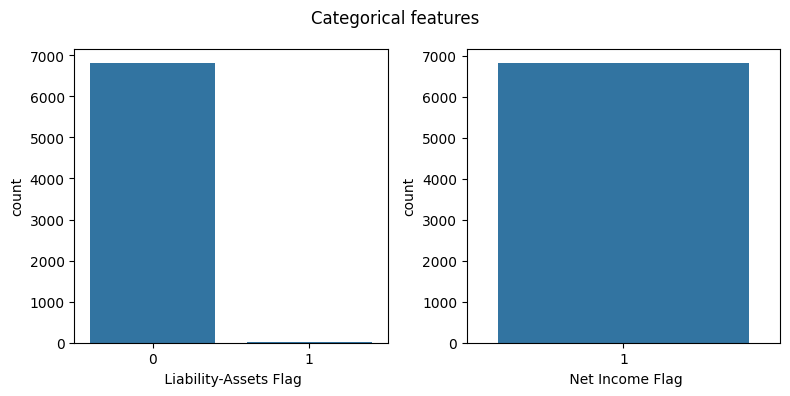

In [12]:
selected_ncols = 2

selected_nrows = int((len(categorical_features) - len(categorical_features) % selected_ncols) / selected_ncols)
if len(categorical_features) % selected_ncols != 0:
    selected_nrows += 1

fig = plt.figure(figsize=(8, 4))
for feat in categorical_features:
    plt.subplot(selected_nrows, selected_ncols, categorical_features.index(feat)+1)
    sns.countplot(x=feat, data=data)
    # plt.title(feat)
    # plt.xticks(rotation=90)
plt.suptitle('Categorical features')
plt.tight_layout()

## Numerical features

In [13]:
data[numerical_features].describe().transpose()

count      mean  \
ROA(C) before interest and depreciation before ...  6819.0  0.505180   
ROA(A) before interest and % after tax              6819.0  0.558625   
ROA(B) before interest and depreciation after tax   6819.0  0.553589   
Operating Gross Margin                              6819.0  0.607948   
Realized Sales Gross Margin                         6819.0  0.607929   
...                                                    ...       ...   
Net Income to Stockholder's Equity                  6819.0  0.840402   
Liability to Equity                                 6819.0  0.280365   
Degree of Financial Leverage (DFL)                  6819.0  0.027541   
Interest Coverage Ratio (Interest expense to EBIT)  6819.0  0.565358   
Equity to Liability                                 6819.0  0.047578   

                                                         std  min       25%  \
ROA(C) before interest and depreciation before ...  0.060686  0.0  0.476527   
ROA(A) before interest and % after tax              0.065620  0.0  0.535543   
ROA(B) before interest and depreciation after tax   0.061595  0.0  0.527277   
Operating Gross Margin                              0.016934  0.0  0.600445   
Realized Sales Gross Margin                         0.016916  0.0  0.600434   
...                                                      ...  ...       ...   
Net Income to Stockholder's Equity                  0.014523  0.0  0.840115   
Liability to Equity                                 0.014463  0.0  0.276944   
Degree of Financial Leverage (DFL)                  0.015668  0.0  0.026791   
Interest Coverage Ratio (Interest expense to EBIT)  0.013214  0.0  0.565158   
Equity to Liability                                 0.050014  0.0  0.024477   

                                                         50%       75%  max  
ROA(C) before interest and depreciation before ...  0.502706  0.535563  1.0  
ROA(A) before interest and % after tax              0.559802  0.589157  1.0  
ROA(B) before interest and depreciation after tax   0.552278  0.584105  1.0  
Operating Gross Margin                              0.605997  0.613914  1.0  
Realized Sales Gross Margin                         0.605976  0.613842  1.0  
...                                                      ...       ...  ...  
Net Income to Stockholder's Equity                  0.841179  0.842357  1.0  
Liability to Equity                                 0.278778  0.281449  1.0  
Degree of Financial Leverage (DFL)                  0.026808  0.026913  1.0  
Interest Coverage Ratio (Interest expense to EBIT)  0.565252  0.565725  1.0  
Equity to Liability                                 0.033798  0.052838  1.0  

[93 rows x 8 columns]

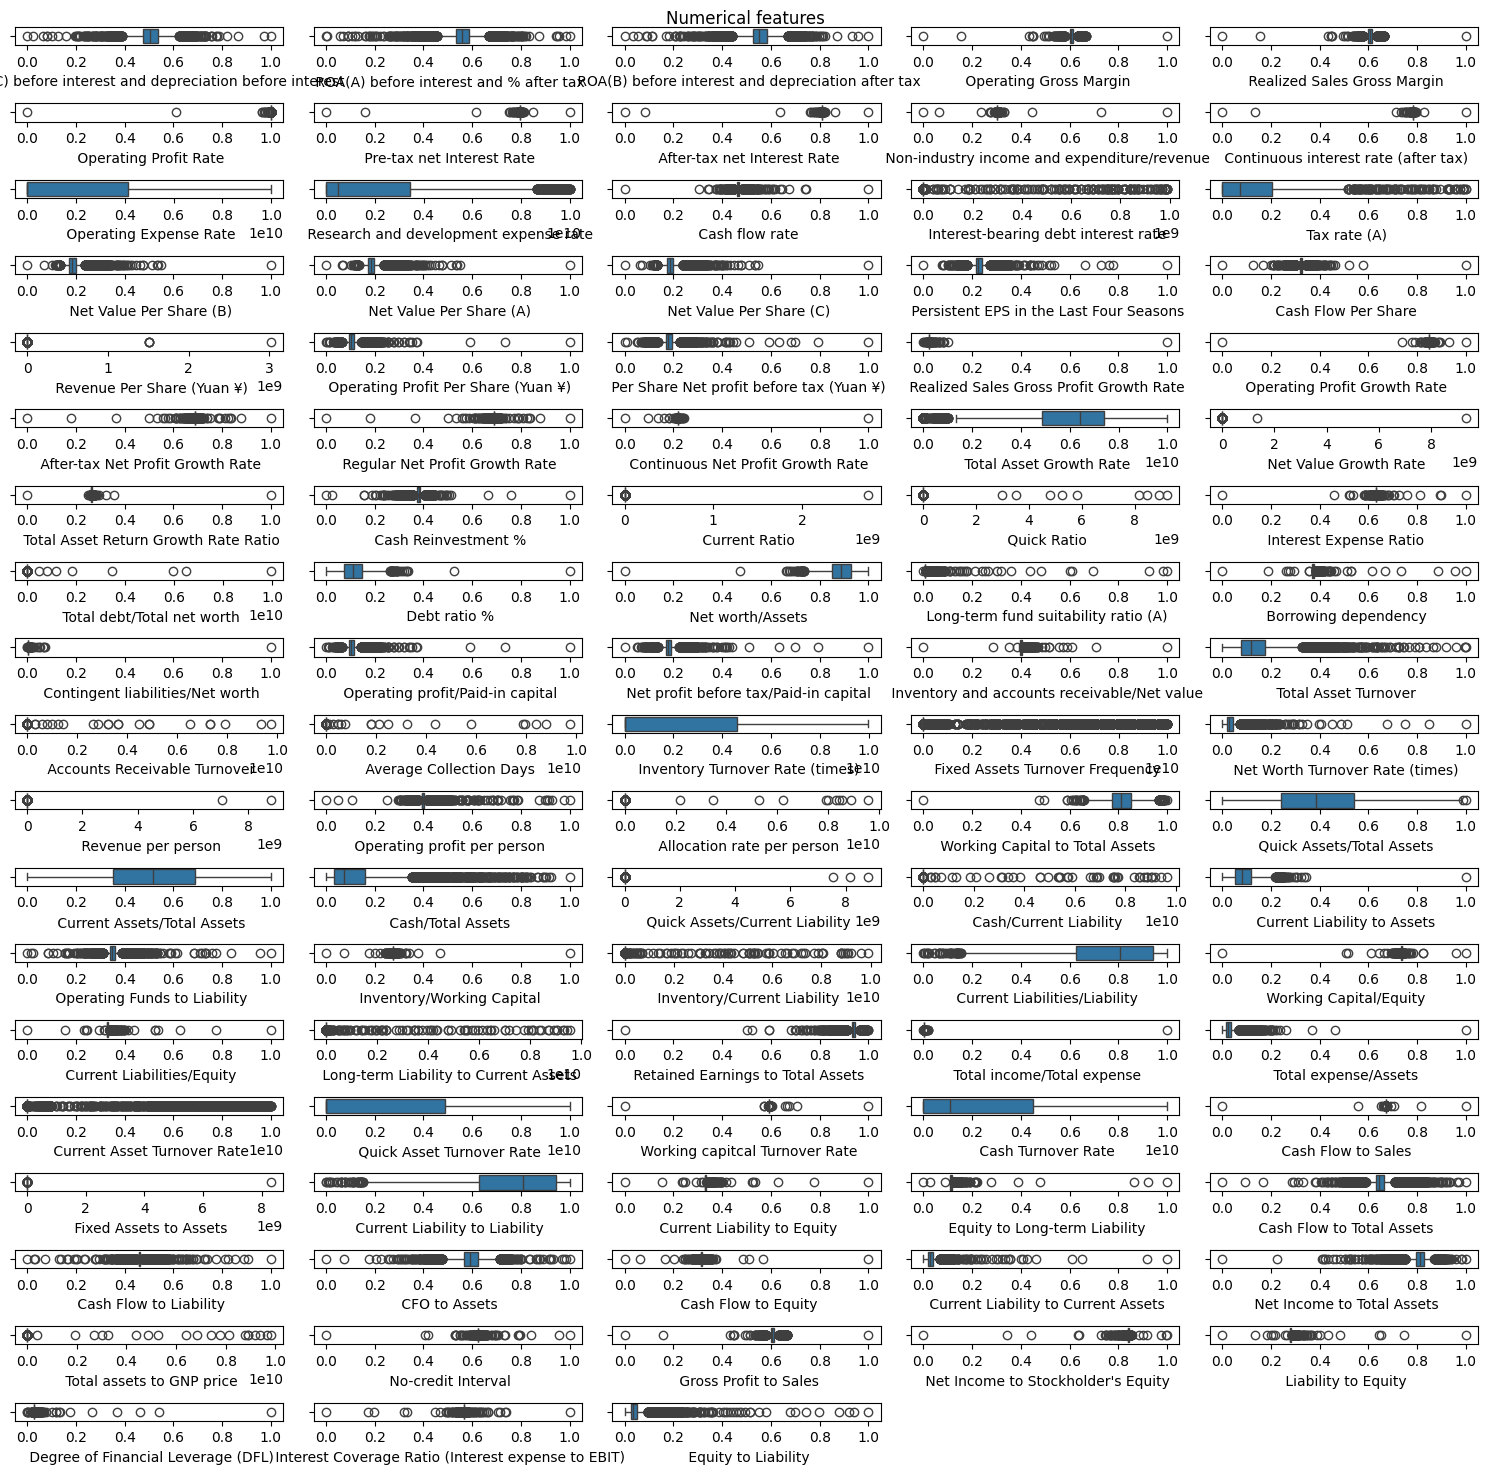

In [15]:
selected_ncols = 5

selected_nrows = int((len(numerical_features) - len(numerical_features) % selected_ncols) / selected_ncols)
if len(numerical_features) % selected_ncols != 0:
    selected_nrows += 1

fig = plt.figure(figsize=(15, 15))
for feat in numerical_features:
    plt.subplot(selected_nrows, selected_ncols, numerical_features.index(feat)+1)
    sns.boxplot(x=feat, data=data)
    # plt.title(feat)
plt.suptitle('Numerical features')
plt.tight_layout()

## Target

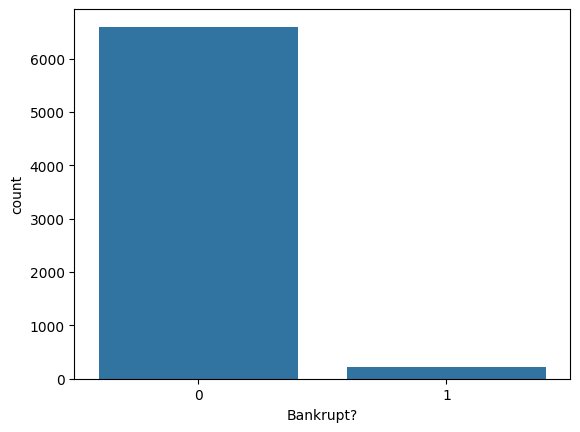

In [16]:
sns.countplot(x='Bankrupt?', data=data);

In [17]:
data['Bankrupt?'].value_counts(normalize=True)

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

# Bivariate analysis

## Target vs categorical

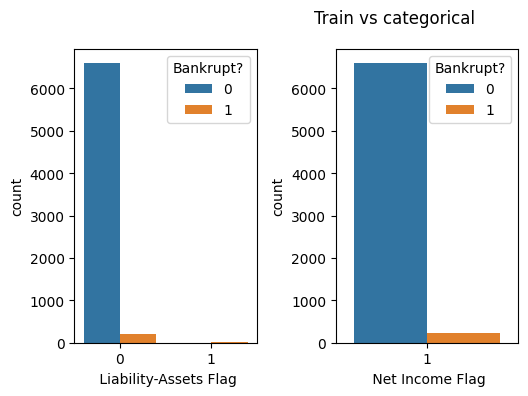

In [19]:
selected_ncols = 3

selected_nrows = int((len(categorical_features) - len(categorical_features) % selected_ncols) / selected_ncols)
if len(categorical_features) % selected_ncols != 0:
    selected_nrows += 1

fig = plt.figure(figsize=(8, 4))
for feat in categorical_features:
    plt.subplot(selected_nrows, selected_ncols, categorical_features.index(feat)+1)
    sns.countplot(x=feat, data=data, hue='Bankrupt?')
    # plt.title(feat)
    # plt.xticks(rotation=90)
plt.suptitle('Train vs categorical')
plt.tight_layout()

## Target vs numeric

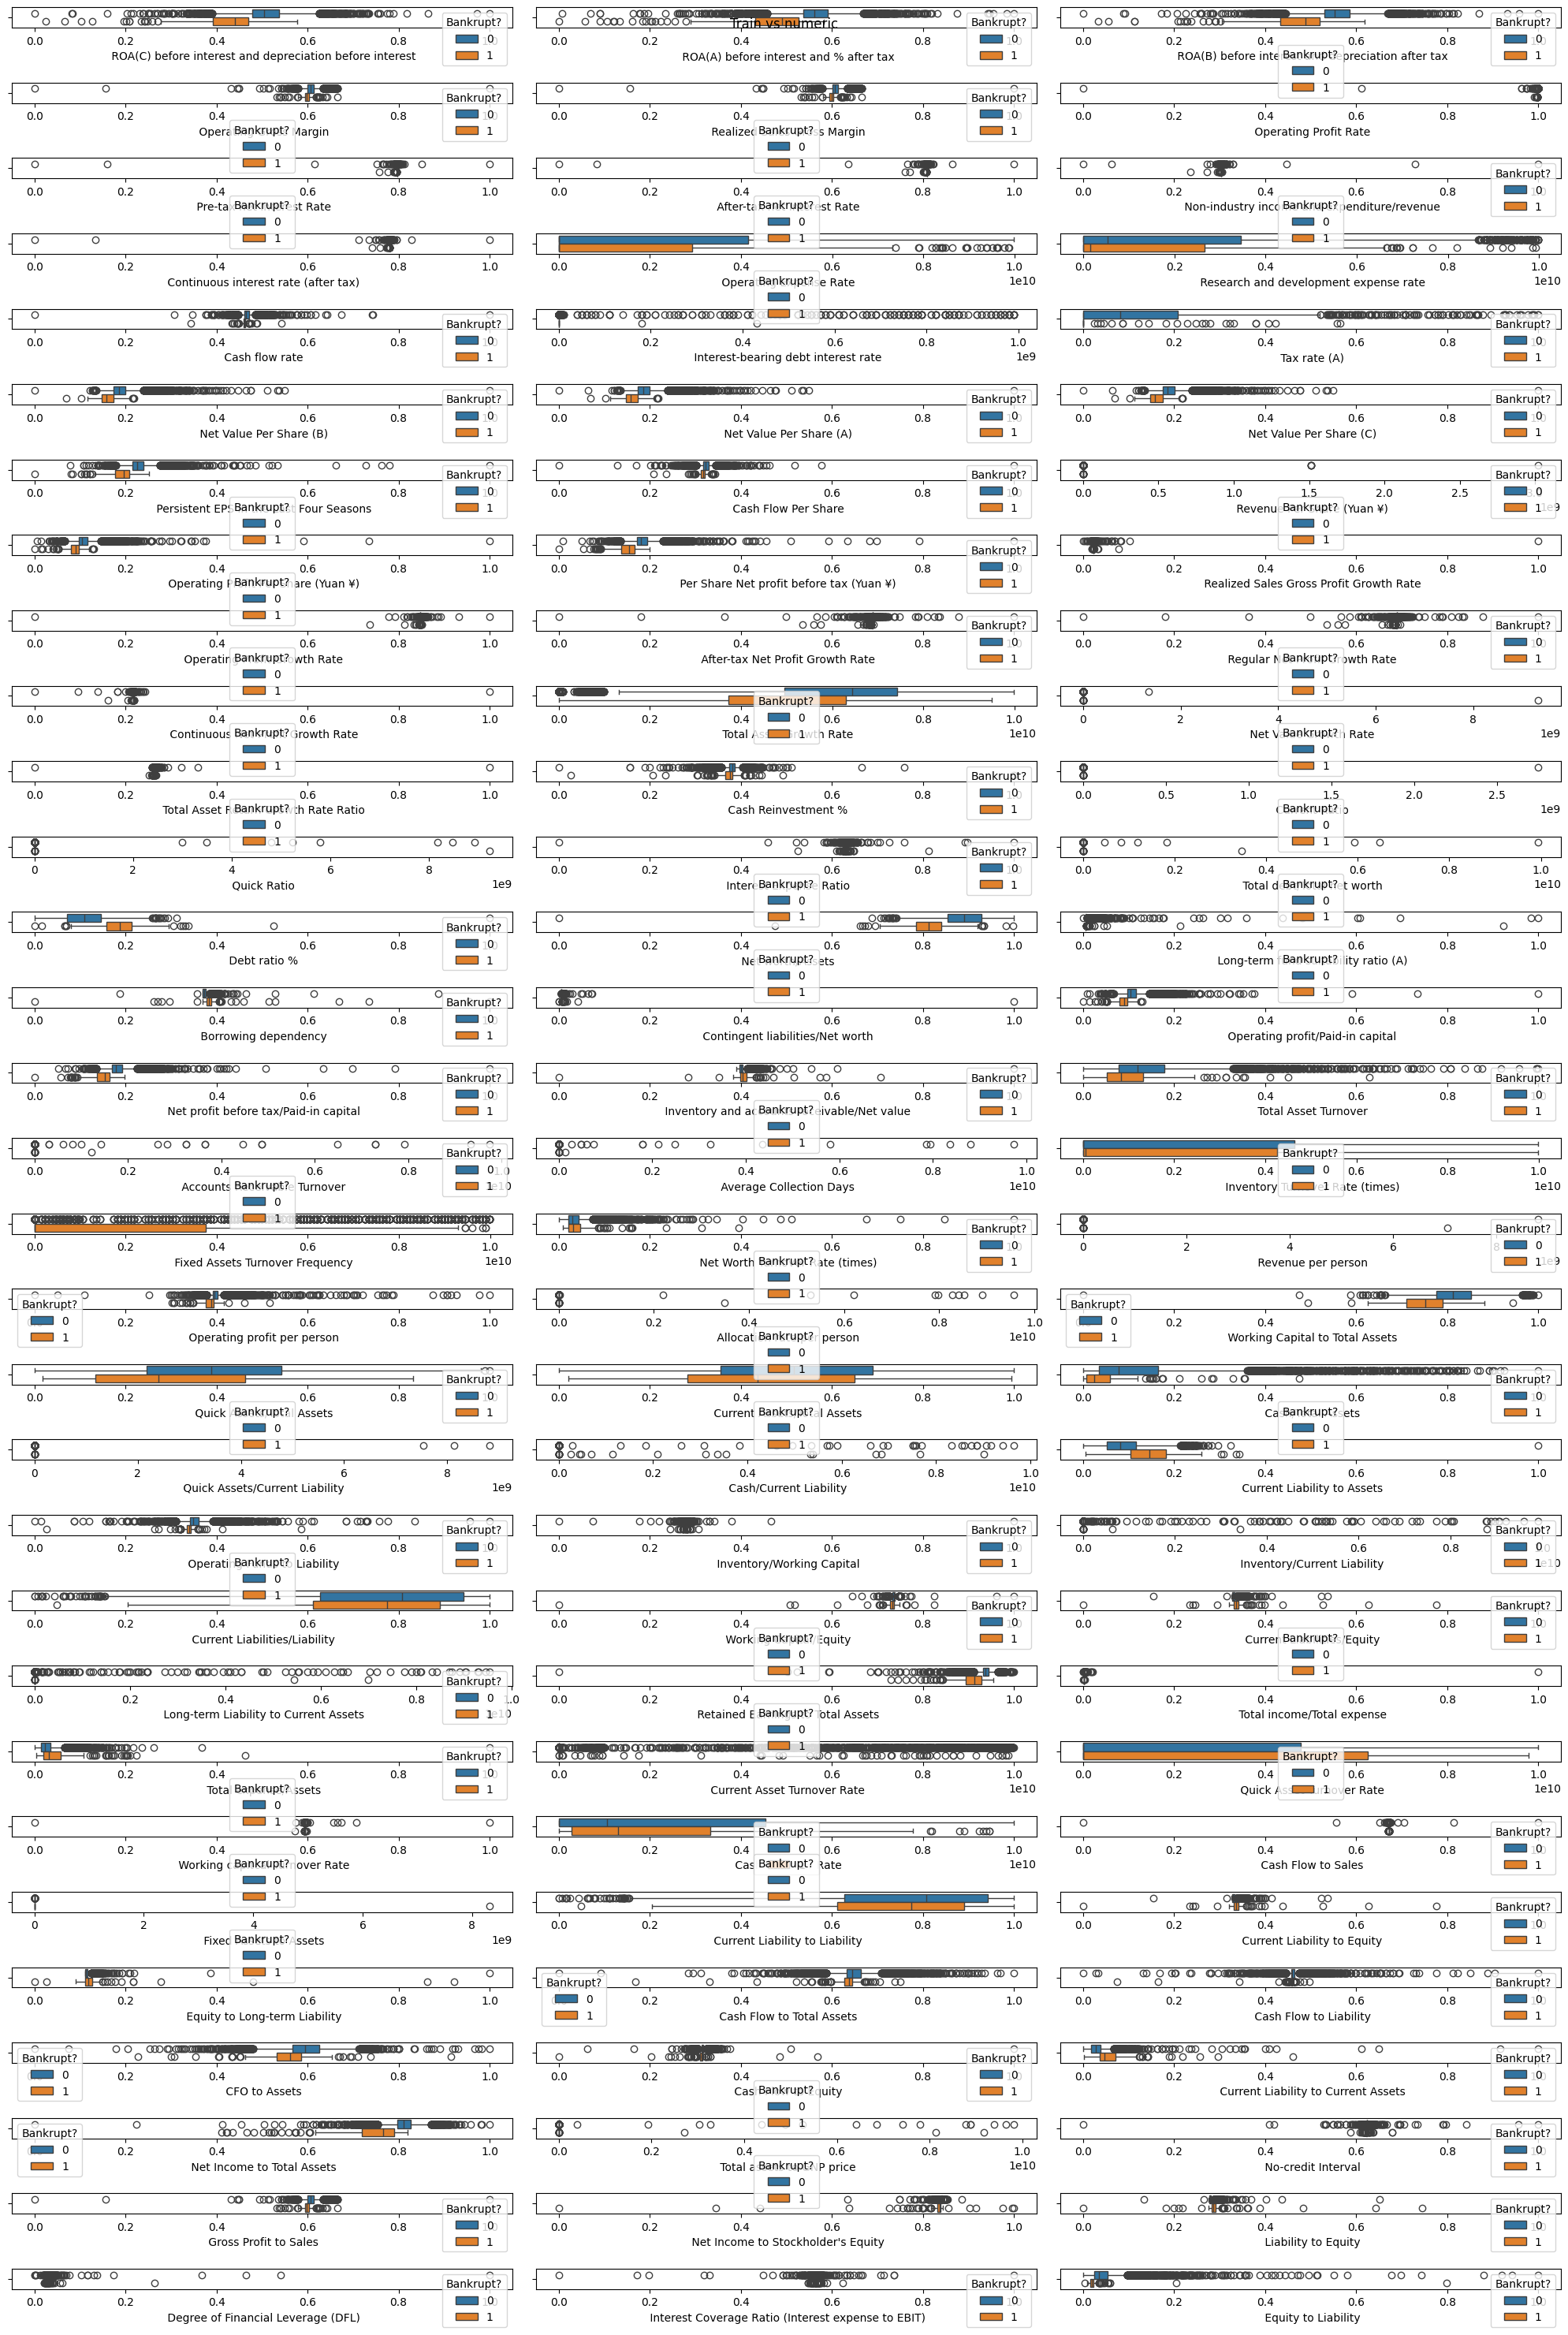

In [23]:
selected_ncols = 3

selected_nrows = int((len(numerical_features) - len(numerical_features) % selected_ncols) / selected_ncols)
if len(numerical_features) % selected_ncols != 0:
    selected_nrows += 1

fig = plt.figure(figsize=(20, 30))
for feat in numerical_features:
    plt.subplot(selected_nrows, selected_ncols, numerical_features.index(feat)+1)
    sns.boxplot(x=feat, data=data, hue='Bankrupt?')
    # plt.title(feat)
    # plt.xticks(rotation=90)
plt.suptitle('Train vs numeric')
plt.tight_layout()

## Categorical vs numeric

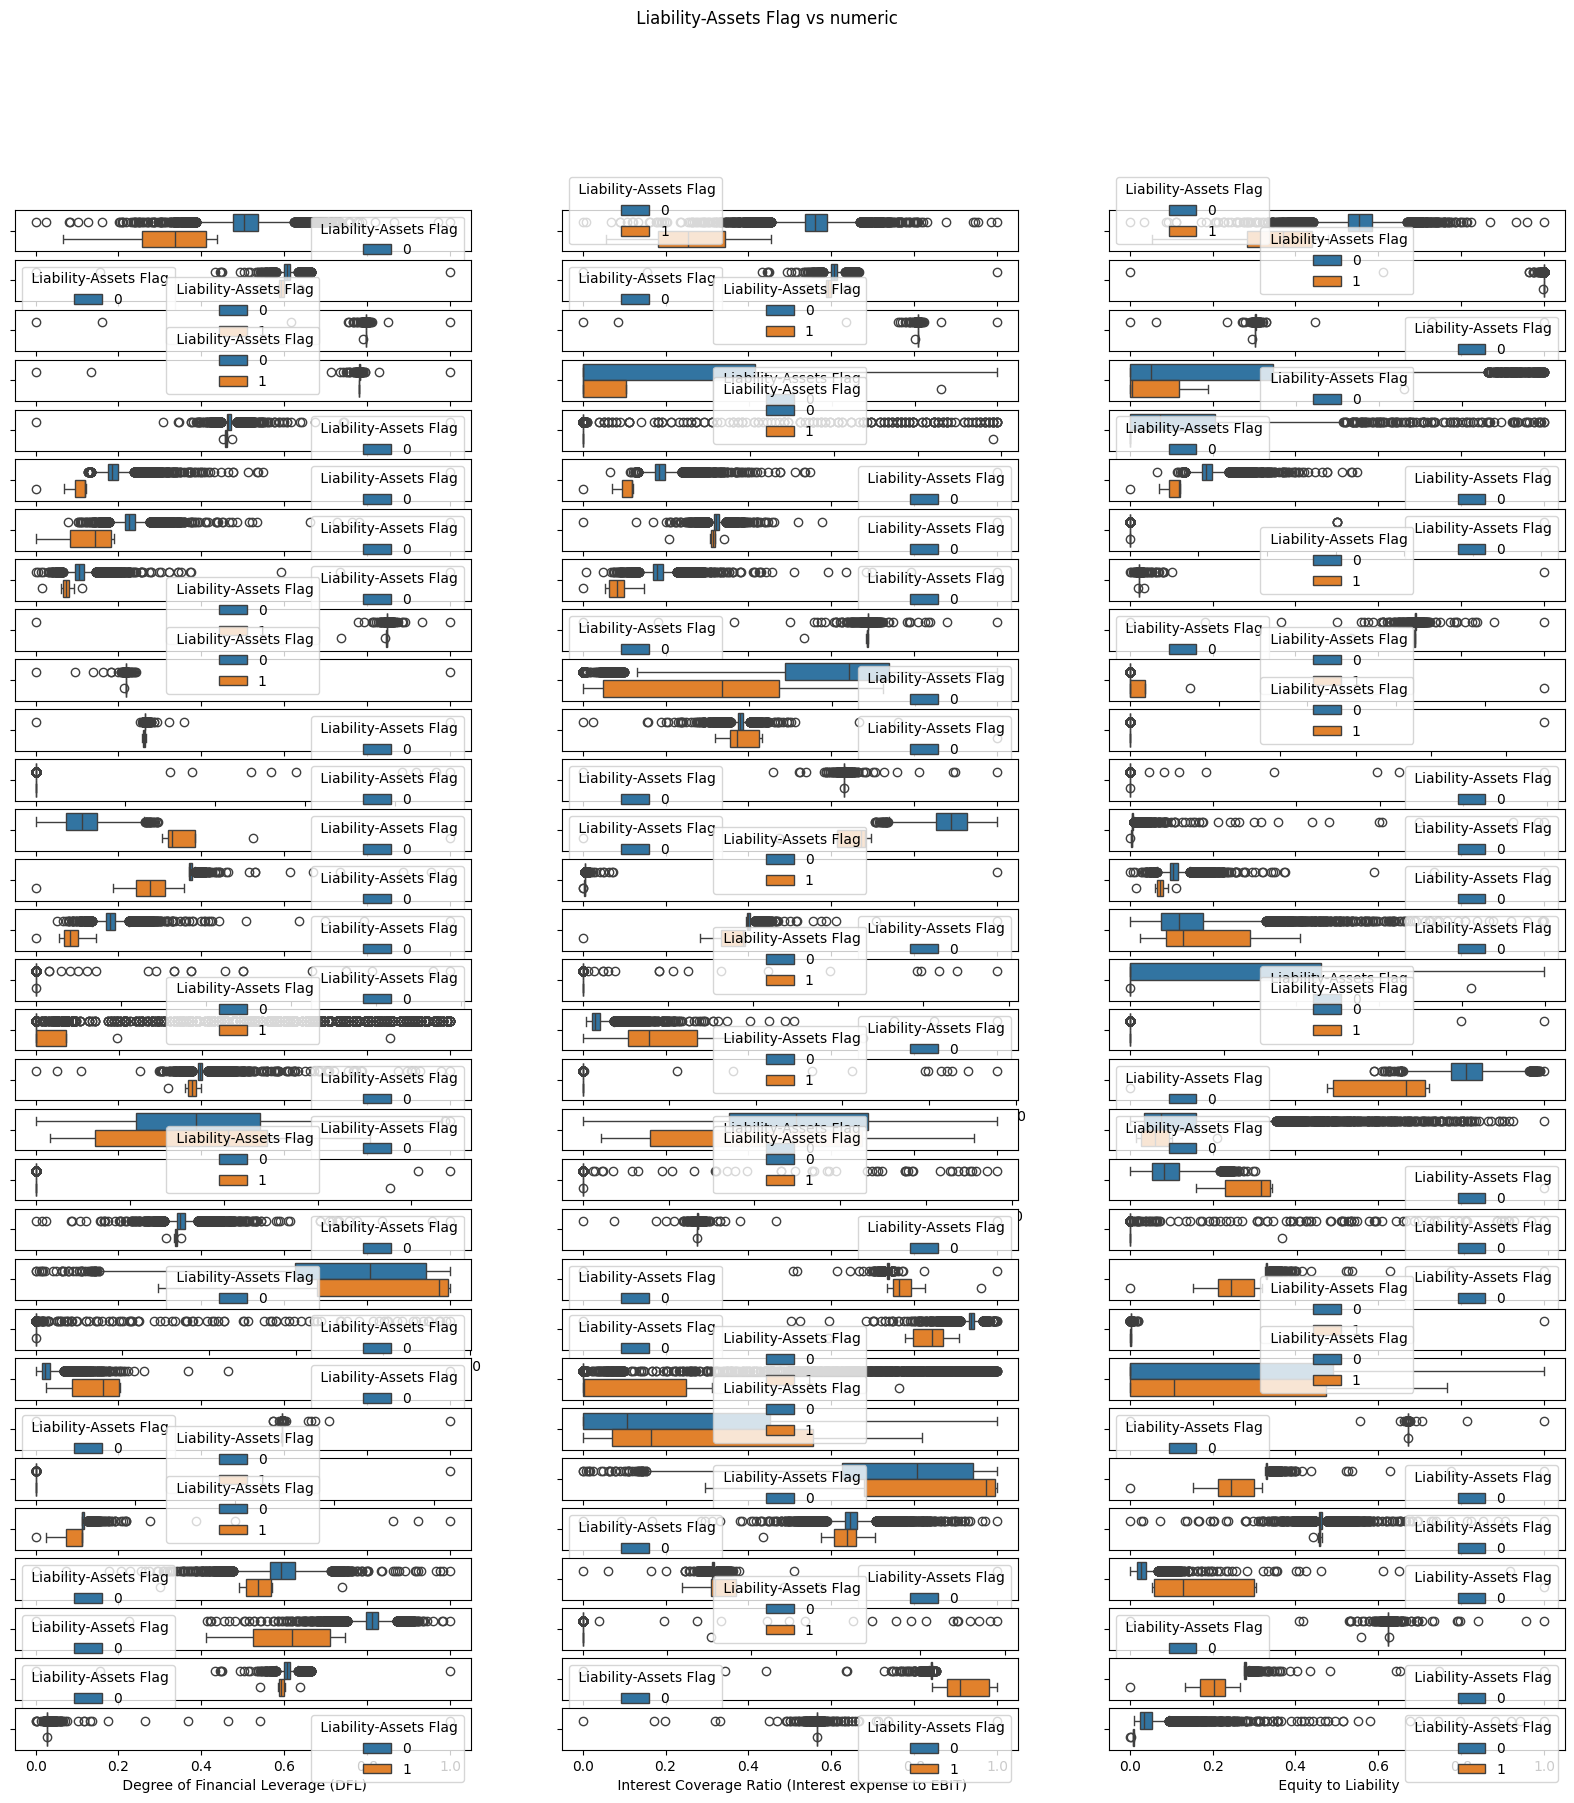

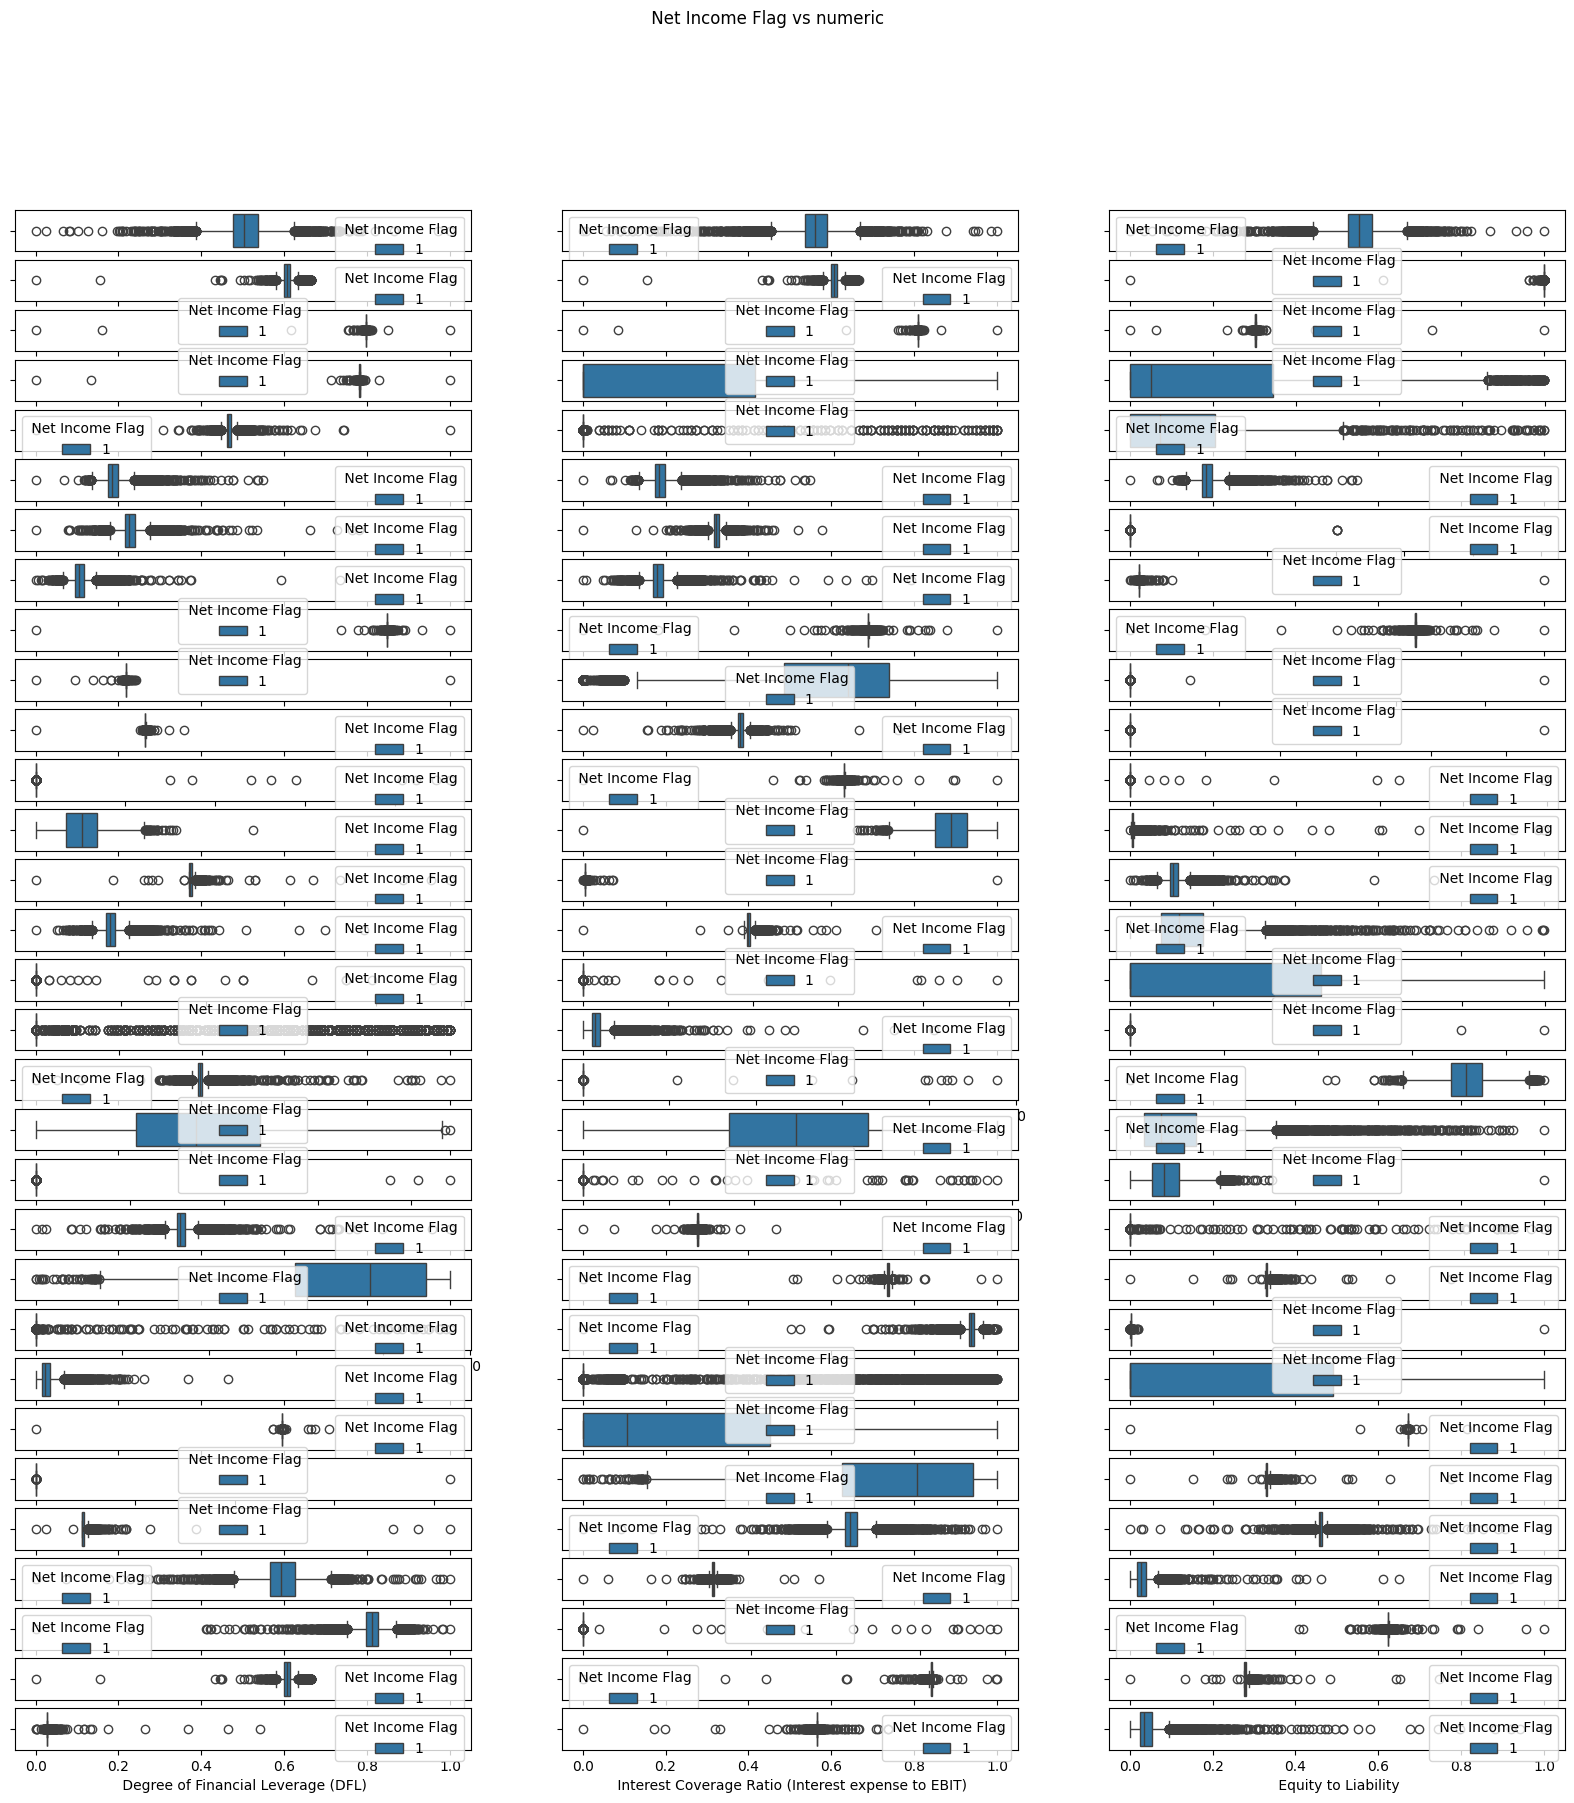

In [21]:
for cat_feat in categorical_features:

    selected_ncols = 3

    selected_nrows = int((len(numerical_features) - len(numerical_features) % selected_ncols) / selected_ncols)
    if len(numerical_features) % selected_ncols != 0:
        selected_nrows += 1

    fig = plt.figure(figsize=(20, 20))
    for feat in numerical_features:
        plt.subplot(selected_nrows, selected_ncols, numerical_features.index(feat)+1)
        sns.boxplot(x=feat, data=data, hue=cat_feat)
        # plt.title(feat)
        # plt.xticks(rotation=90)
    plt.suptitle(f'{cat_feat} vs numeric')
    plt.tight_layout()

## Numeric vs numeric

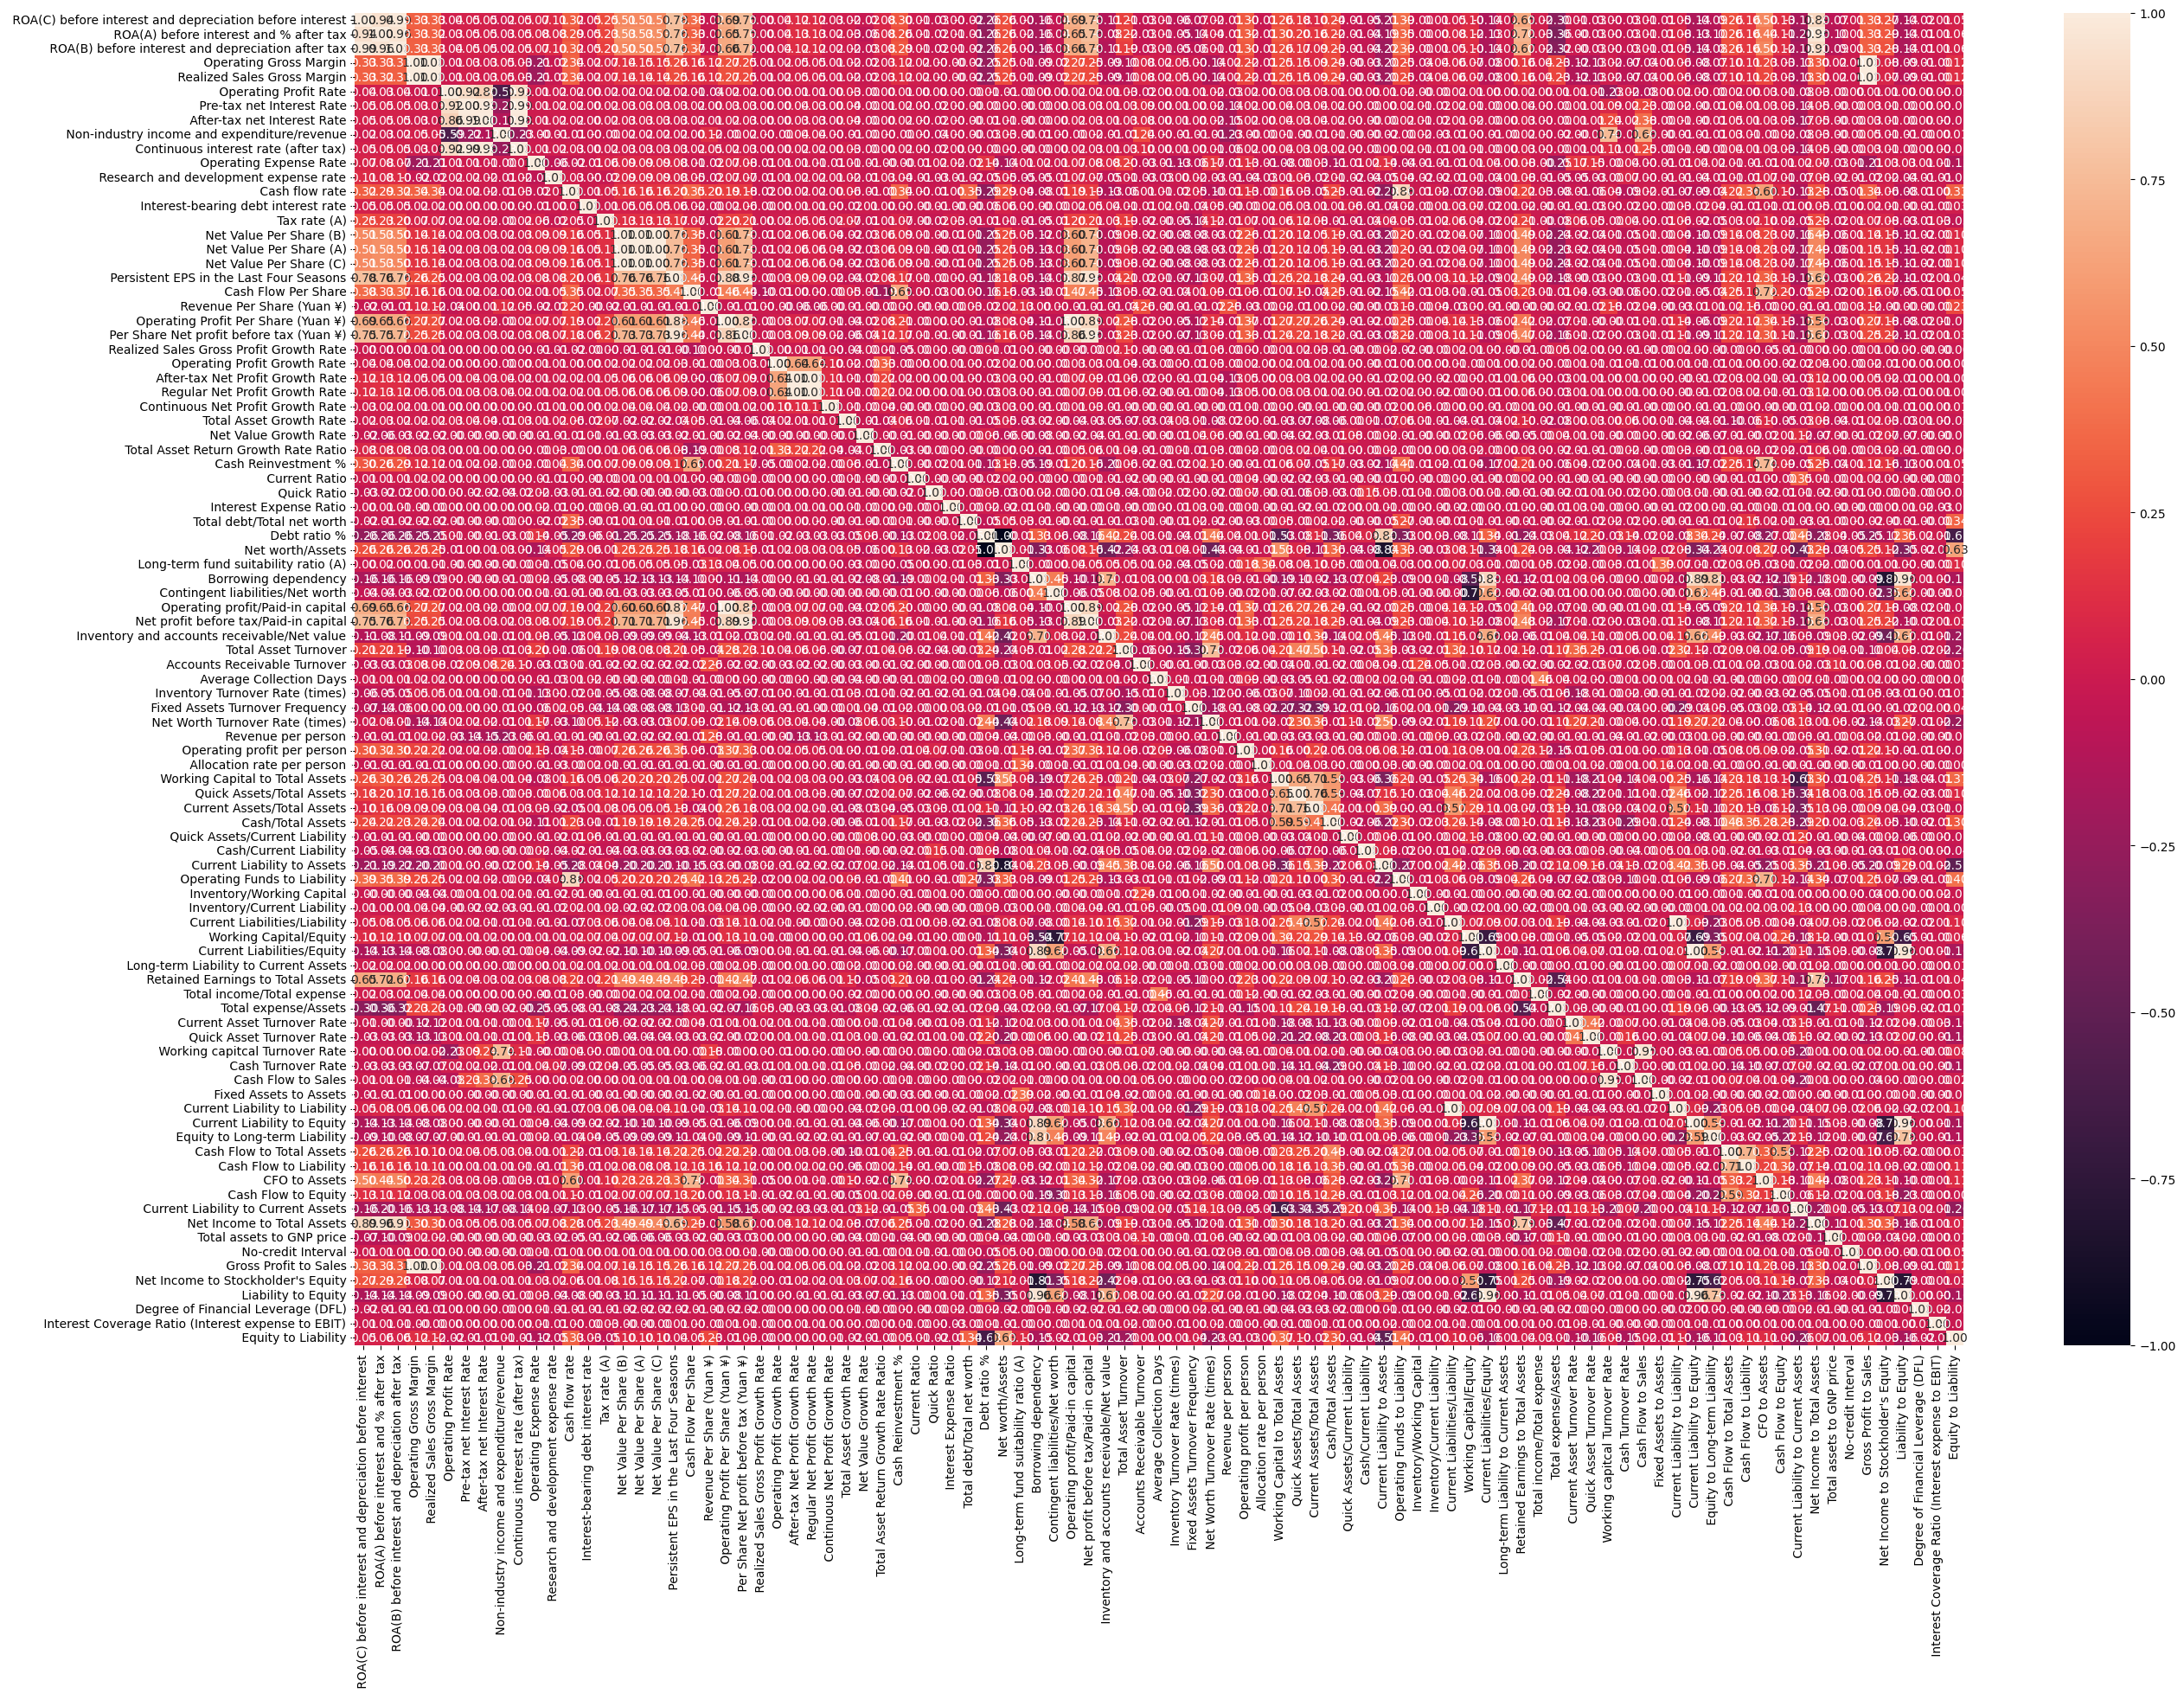

In [24]:
corr_values = data[numerical_features].corr()

fig = plt.figure(figsize=(30, 20))
sns.heatmap(corr_values, annot=True, fmt='.2f');

# Splitting data into train and test sets

In [7]:
train_df, test_df = train_test_split(data, test_size=0.1, random_state=13, stratify=data['Bankrupt?'])

In [8]:
train_df.shape, test_df.shape

((6137, 96), (682, 96))

In [10]:
train_df['Bankrupt?'].value_counts(normalize=True)

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

In [11]:
test_df['Bankrupt?'].value_counts(normalize=True)

Bankrupt?
0    0.967742
1    0.032258
Name: proportion, dtype: float64

## Distribution of categorical features

In [17]:
for feat in categorical_features:
    print(f"##### {feat} #####")
    print("Train: ")
    display(train_df[feat].value_counts(normalize=True))
    print("Test: ")
    display(test_df[feat].value_counts(normalize=True))

#####  Liability-Assets Flag #####
Train: 


 Liability-Assets Flag
0    0.998859
1    0.001141
Name: proportion, dtype: float64

Test: 


 Liability-Assets Flag
0    0.998534
1    0.001466
Name: proportion, dtype: float64

#####  Net Income Flag #####
Train: 


 Net Income Flag
1    1.0
Name: proportion, dtype: float64

Test: 


 Net Income Flag
1    1.0
Name: proportion, dtype: float64

## Distribution of numerical features

If we want to check, if two data series are part of the same distribution, we can use the Two-Sided Kolmogorov-Smirnov-Test, which measures the maximum distance between the empirical cumulative distribution functions of two data series. 
<br>Two identical data series would give us a statistic value of 0 ("the maximum distance between the two CDF") and a p value of 1 ("how sure we can be that based on the data we have this is true").
<br>
So in order to be sure that two data series origin from the same distribution, we're looking for low statistic values and high p values.
<br>
Or as the scipy documentation puts it:
<br>
If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [22]:
for feat in numerical_features:
    ks_result = ks_2samp(train_df[feat], test_df[feat])
    if ks_result[1] <= 0.05:
        print(f"{feat} (p={ks_result[1]:.4f}) distribution is different!!!")
    # print(ks_2samp(train_df[feat], test_df[feat]))

 ROA(C) before interest and depreciation before interest (p=0.0402) distribution is different!!!
 Tax rate (A) (p=0.0445) distribution is different!!!
 Persistent EPS in the Last Four Seasons (p=0.0365) distribution is different!!!
 Cash Flow to Sales (p=0.0321) distribution is different!!!
 Cash Flow to Total Assets (p=0.0449) distribution is different!!!
 Cash Flow to Equity (p=0.0217) distribution is different!!!
 Net Income to Stockholder's Equity (p=0.0357) distribution is different!!!


In [12]:
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)